Before running the file Upload all your data set on your goole drive in a zip format

In [ ]:
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import glob
import numpy as np
import cv2
import copy
video_files =  glob.glob('/content/drive/MyDrive/Train_Deepfaskedataset/*.mp4')
frame_count = []
for video_file in video_files:
  cap = cv2.VideoCapture(video_file)
  if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<150):
    video_files.remove(video_file)
    continue
  frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames" , frame_count)
print("Total number of videos: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames [727, 217, 596, 901, 225, 292, 843, 1045, 727, 605, 843, 898, 504, 240, 737, 1279, 1076, 458, 499, 1278, 225, 641, 792, 821, 985, 991, 484, 632, 258, 627, 265, 1058, 633, 634, 1075, 262, 259, 995, 1280, 990, 1278, 776, 637, 458, 259, 208, 982, 1269, 574, 1082, 208, 685, 990, 960, 1453, 974, 839, 815, 713, 940, 533, 664, 960, 910, 795, 958, 446, 532, 711, 650, 446, 910, 839, 456, 940, 943, 943, 839, 713, 533, 534, 960, 531, 910, 955, 533, 710, 543, 796, 764, 862, 840, 810, 1447, 382, 810, 446, 481, 367, 471, 840, 861, 328, 932, 434, 840, 453, 669, 845, 875, 420, 810, 315, 816, 420, 1255, 405, 655, 405, 301, 260, 835, 586, 689, 621, 1239, 1246, 977, 315, 565, 686, 301, 625, 593, 661, 1358, 1255, 262, 720, 915, 1177, 687, 1180, 976, 684, 703, 532, 477, 1544, 1567, 1079, 580, 1002, 759, 704, 723, 560, 857, 563, 855, 422, 613, 744, 276, 707, 387, 403, 656, 543, 652, 541, 432, 591, 335, 579, 874, 965, 1489, 787, 860, 851, 560, 1045, 800, 626, 1085, 834, 610, 805, 371, 364, 855, 985, 5

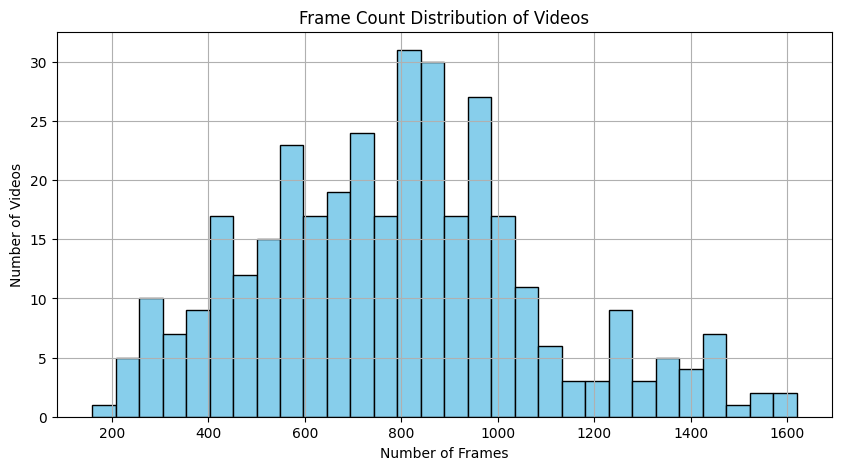

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(frame_count, bins=30, color='skyblue', edgecolor='black')
plt.title('Frame Count Distribution of Videos')
plt.xlabel('Number of Frames')
plt.ylabel('Number of Videos')
plt.grid(True)
plt.show()


In [ ]:
import torch
import torchvision
from torchvision import transforms

In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=72d9e24b00459d95858c8367d5a4eb3173a8ed202570d2a489b9b4e5d5a6cd08
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


In [ ]:
!pip install cmake dlib

In [ ]:
!pip install mtcnn

In [ ]:
!pip install facenet-pytorch

In [ ]:
import os
import cv2
import torch
from facenet_pytorch import MTCNN
from tqdm import tqdm
import glob

In [ ]:
input_dir = "/content/drive/MyDrive/REAL_Face_data"
output_dir = "/content/drive/MyDrive/Hello_World"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)
video_paths = glob.glob(os.path.join(input_dir, "*.mp4"))
for video_path in tqdm(video_paths, desc="Processing videos"):
    try:
        filename = os.path.basename(video_path)
        output_path = os.path.join(output_dir, filename)

        if os.path.exists(output_path):
            print(f"Skipping {filename}: output already exists.")
            continue
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Failed to open {filename}. Skipping.")
            continue
        fps = cap.get(cv2.CAP_PROP_FPS)
        if fps is None or fps <= 0:
            fps = 30.0
        face_frames = []
        frame_count = 0
        max_frames = 150
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            if frame_count % 4 != 0:
               continue
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            boxes, _ = mtcnn.detect(rgb_frame)
            if boxes is not None:
                areas = [(b[2] - b[0]) * (b[3] - b[1]) for b in boxes]
                max_idx = int(areas.index(max(areas)))
                x1, y1, x2, y2 = boxes[max_idx].astype(int)
                x1, y1 = max(0, x1), max(0, y1)
                x2 = min(frame.shape[1], x2)
                y2 = min(frame.shape[0], y2)

                if x2 > x1 and y2 > y1:
                    face = frame[y1:y2, x1:x2]
                    face = cv2.resize(face, (112, 112))
                    face_frames.append(face)
        cap.release()
        if len(face_frames) > 0:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (112, 112))
            for f in face_frames:
                out.write(f)
            out.release()
            print(f"Saved {output_path} with {len(face_frames)} face frames.")
        else:
            print(f"No faces found in {filename}. Output not created.")
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        continue

Processing videos:   2%|▏         | 1/53 [00:57<50:09, 57.87s/it]

Saved /content/drive/MyDrive/Hello_World/01__secret_conversation.mp4 with 37 face frames.


Processing videos:   4%|▍         | 2/53 [01:32<37:21, 43.95s/it]

Saved /content/drive/MyDrive/Hello_World/01__talking_angry_couch.mp4 with 37 face frames.


Processing videos:   6%|▌         | 3/53 [02:13<35:30, 42.61s/it]

Saved /content/drive/MyDrive/Hello_World/01__hugging_happy.mp4 with 37 face frames.


Processing videos:   8%|▊         | 4/53 [02:49<32:44, 40.10s/it]

Saved /content/drive/MyDrive/Hello_World/01__talking_against_wall.mp4 with 37 face frames.


Processing videos:   9%|▉         | 5/53 [03:31<32:43, 40.91s/it]

Saved /content/drive/MyDrive/Hello_World/01__outside_talking_still_laughing.mp4 with 37 face frames.


Processing videos:  11%|█▏        | 6/53 [04:09<31:09, 39.77s/it]

Saved /content/drive/MyDrive/Hello_World/01__kitchen_pan.mp4 with 37 face frames.


Processing videos:  13%|█▎        | 7/53 [04:45<29:32, 38.54s/it]

Saved /content/drive/MyDrive/Hello_World/01__meeting_serious.mp4 with 37 face frames.


Processing videos:  15%|█▌        | 8/53 [05:23<28:55, 38.57s/it]

Saved /content/drive/MyDrive/Hello_World/01__kitchen_still.mp4 with 37 face frames.


Processing videos:  17%|█▋        | 9/53 [06:08<29:40, 40.46s/it]

Saved /content/drive/MyDrive/Hello_World/01__outside_talking_pan_laughing.mp4 with 35 face frames.


Processing videos:  19%|█▉        | 10/53 [07:05<32:41, 45.62s/it]

Saved /content/drive/MyDrive/Hello_World/01__walking_and_outside_surprised.mp4 with 37 face frames.


Processing videos:  21%|██        | 11/53 [07:40<29:42, 42.45s/it]

Saved /content/drive/MyDrive/Hello_World/01__walking_down_indoor_hall_disgust.mp4 with 37 face frames.


Processing videos:  23%|██▎       | 12/53 [08:35<31:26, 46.02s/it]

Saved /content/drive/MyDrive/Hello_World/01__walking_down_street_outside_angry.mp4 with 37 face frames.


Processing videos:  25%|██▍       | 13/53 [09:12<29:01, 43.55s/it]

Saved /content/drive/MyDrive/Hello_World/02__hugging_happy.mp4 with 37 face frames.


Processing videos:  26%|██▋       | 14/53 [09:47<26:30, 40.79s/it]

Saved /content/drive/MyDrive/Hello_World/01__walk_down_hall_angry.mp4 with 37 face frames.


Processing videos:  28%|██▊       | 15/53 [10:20<24:23, 38.50s/it]

Saved /content/drive/MyDrive/Hello_World/02__exit_phone_room.mp4 with 37 face frames.


Processing videos:  30%|███       | 16/53 [11:01<24:07, 39.12s/it]

Saved /content/drive/MyDrive/Hello_World/02__kitchen_still.mp4 with 37 face frames.


Processing videos:  32%|███▏      | 17/53 [11:41<23:38, 39.40s/it]

Saved /content/drive/MyDrive/Hello_World/02__meeting_serious.mp4 with 37 face frames.


Processing videos:  34%|███▍      | 18/53 [12:17<22:25, 38.44s/it]

Saved /content/drive/MyDrive/Hello_World/02__kitchen_pan.mp4 with 34 face frames.


Processing videos:  36%|███▌      | 19/53 [13:05<23:22, 41.24s/it]

Saved /content/drive/MyDrive/Hello_World/01__walking_outside_cafe_disgusted.mp4 with 37 face frames.


Processing videos:  38%|███▊      | 20/53 [13:42<22:00, 40.02s/it]

Saved /content/drive/MyDrive/Hello_World/02__outside_talking_pan_laughing.mp4 with 37 face frames.


Processing videos:  40%|███▉      | 21/53 [14:19<20:53, 39.17s/it]

Saved /content/drive/MyDrive/Hello_World/02__outside_talking_still_laughing.mp4 with 37 face frames.


Processing videos:  42%|████▏     | 22/53 [14:57<20:04, 38.85s/it]

Saved /content/drive/MyDrive/Hello_World/03__kitchen_pan.mp4 with 35 face frames.


Processing videos:  43%|████▎     | 23/53 [15:32<18:48, 37.63s/it]

Saved /content/drive/MyDrive/Hello_World/03__exit_phone_room.mp4 with 37 face frames.


Processing videos:  45%|████▌     | 24/53 [16:06<17:43, 36.68s/it]

Saved /content/drive/MyDrive/Hello_World/03__hugging_happy.mp4 with 37 face frames.


Processing videos:  47%|████▋     | 25/53 [16:47<17:42, 37.93s/it]

Saved /content/drive/MyDrive/Hello_World/03__kitchen_still.mp4 with 37 face frames.


Processing videos:  49%|████▉     | 26/53 [17:22<16:40, 37.05s/it]

Saved /content/drive/MyDrive/Hello_World/03__outside_talking_still_laughing.mp4 with 37 face frames.


Processing videos:  51%|█████     | 27/53 [17:58<15:53, 36.67s/it]

Saved /content/drive/MyDrive/Hello_World/03__podium_speech_happy.mp4 with 37 face frames.


Processing videos:  53%|█████▎    | 28/53 [18:37<15:30, 37.23s/it]

Saved /content/drive/MyDrive/Hello_World/03__meeting_serious.mp4 with 37 face frames.


Processing videos:  55%|█████▍    | 29/53 [19:16<15:08, 37.86s/it]

Saved /content/drive/MyDrive/Hello_World/03__talking_angry_couch.mp4 with 37 face frames.


Processing videos:  57%|█████▋    | 30/53 [20:08<16:08, 42.11s/it]

Saved /content/drive/MyDrive/Hello_World/03__secret_conversation.mp4 with 37 face frames.


Processing videos:  58%|█████▊    | 31/53 [20:43<14:39, 39.99s/it]

Saved /content/drive/MyDrive/Hello_World/03__talking_against_wall.mp4 with 37 face frames.


Processing videos:  60%|██████    | 32/53 [21:24<14:06, 40.33s/it]

Saved /content/drive/MyDrive/Hello_World/03__walking_and_outside_surprised.mp4 with 37 face frames.


Processing videos:  62%|██████▏   | 33/53 [22:02<13:12, 39.60s/it]

Saved /content/drive/MyDrive/Hello_World/04__kitchen_pan.mp4 with 34 face frames.


Processing videos:  64%|██████▍   | 34/53 [22:53<13:38, 43.07s/it]

Saved /content/drive/MyDrive/Hello_World/03__walking_down_street_outside_angry.mp4 with 37 face frames.


Processing videos:  66%|██████▌   | 35/53 [23:30<12:21, 41.18s/it]

Saved /content/drive/MyDrive/Hello_World/04__outside_talking_pan_laughing.mp4 with 36 face frames.


Processing videos:  68%|██████▊   | 36/53 [24:07<11:21, 40.08s/it]

Saved /content/drive/MyDrive/Hello_World/03__walking_outside_cafe_disgusted.mp4 with 37 face frames.


Processing videos:  70%|██████▉   | 37/53 [24:50<10:55, 40.97s/it]

Saved /content/drive/MyDrive/Hello_World/03__walking_down_indoor_hall_disgust.mp4 with 37 face frames.


Processing videos:  72%|███████▏  | 38/53 [25:25<09:44, 38.99s/it]

Saved /content/drive/MyDrive/Hello_World/04__exit_phone_room.mp4 with 37 face frames.


Processing videos:  74%|███████▎  | 39/53 [25:57<08:36, 36.88s/it]

Saved /content/drive/MyDrive/Hello_World/03__walk_down_hall_angry.mp4 with 37 face frames.


Processing videos:  75%|███████▌  | 40/53 [26:35<08:04, 37.30s/it]

Saved /content/drive/MyDrive/Hello_World/04__talking_angry_couch.mp4 with 37 face frames.


Processing videos:  77%|███████▋  | 41/53 [27:12<07:27, 37.33s/it]

Saved /content/drive/MyDrive/Hello_World/04__talking_against_wall.mp4 with 37 face frames.


Processing videos:  79%|███████▉  | 42/53 [27:47<06:41, 36.49s/it]

Saved /content/drive/MyDrive/Hello_World/04__podium_speech_happy.mp4 with 37 face frames.


Processing videos:  81%|████████  | 43/53 [28:23<06:04, 36.40s/it]

Saved /content/drive/MyDrive/Hello_World/05__hugging_happy.mp4 with 37 face frames.


Processing videos:  83%|████████▎ | 44/53 [28:57<05:21, 35.75s/it]

Saved /content/drive/MyDrive/Hello_World/04__walk_down_hall_angry.mp4 with 37 face frames.


Processing videos:  85%|████████▍ | 45/53 [29:33<04:45, 35.64s/it]

Saved /content/drive/MyDrive/Hello_World/04__walking_outside_cafe_disgusted.mp4 with 37 face frames.


Processing videos:  87%|████████▋ | 46/53 [30:15<04:23, 37.65s/it]

Saved /content/drive/MyDrive/Hello_World/05__kitchen_still.mp4 with 37 face frames.


Processing videos:  89%|████████▊ | 47/53 [31:04<04:05, 40.89s/it]

Saved /content/drive/MyDrive/Hello_World/04__walking_down_street_outside_angry.mp4 with 37 face frames.


Processing videos:  91%|█████████ | 48/53 [31:37<03:13, 38.71s/it]

Saved /content/drive/MyDrive/Hello_World/05__exit_phone_room.mp4 with 37 face frames.


Processing videos:  92%|█████████▏| 49/53 [32:13<02:31, 37.91s/it]

Saved /content/drive/MyDrive/Hello_World/05__outside_talking_still_laughing.mp4 with 37 face frames.


Processing videos:  94%|█████████▍| 50/53 [32:51<01:53, 37.73s/it]

Saved /content/drive/MyDrive/Hello_World/05__talking_against_wall.mp4 with 37 face frames.


Processing videos:  96%|█████████▌| 51/53 [33:23<01:12, 36.10s/it]

Saved /content/drive/MyDrive/Hello_World/05__walk_down_hall_angry.mp4 with 36 face frames.


Processing videos:  98%|█████████▊| 52/53 [33:57<00:35, 35.58s/it]

Saved /content/drive/MyDrive/Hello_World/05__podium_speech_happy.mp4 with 37 face frames.


Processing videos: 100%|██████████| 53/53 [34:36<00:00, 39.19s/it]

Saved /content/drive/MyDrive/Hello_World/05__outside_talking_pan_laughing.mp4 with 36 face frames.
